# Pixel Art Upscale
Graphics in past video games were represented at the pixel level. This form of digital art is known as pixel art. This artwork was usually arranged by hand at the pixel level because of the hardware constraints at the time–this is opposed to the standard now of doscaling the high-resolution images. 

We will be attempting to upscaling some iconic pixel art such as mario characters and other classic video game characters. We will start with some older implementation methods that have limitations on the magnification factor and we will finish with the most refined implementation developed by **Johannes Kopf and Dani Lischinski**. 

The implementation by Kopf and Lischinski is most definitely the most advanced algorithm of the 3 that we are attempting to implement. Part of the difficulty is that we do not know what heuristics they are using so we will have to experiment with these numbers on are own. Additionally, have a low number of linear transformations needed, opposed to Kopf and Lischinski's which will require us to reshape the pixels, produce a Voroni graph, initialize spline curves, optimize the spline curves for control points, and render the image based off pixel-color averages.

# Install packages

In [6]:
%conda install --yes --prefix {sys.prefix} networkx

Solving environment: \ ^C
failed with initial frozen solve. Retrying with flexible solve.

CondaError: KeyboardInterrupt


Note: you may need to restart the kernel to use updated packages.


In [2]:
import epx
import cv2
import networkx
import numpy as np
import sys
import utils
import matplotlib.pyplot as plt

%matplotlib inline

# Option 1: Bicubic Upscaling 
Apply linear filtering to upsample images

# Option 2: Pixel Art Upscaling Techniques
Emulation technique that is based on a fixed integer factor EPX.

EPX is a naive solution that increases the resolution of an image by a factor of two using a straightforward approach. At the beginning, every pixel in the original image is replaced by a 2x2 block of pixels with the same color. However, if the adjacent pixels to the left and above the current pixel in the original image have the same color, that color is used to replace the top-left pixel in the 2x2 block. The same logic applies to the other three corners of the block. There are a few more additional constraints that deal with not doing replacement if 3 of the surrounding pixels are equivalent.

Further Detailing on Algorithm:
- https://en.wikipedia.org/wiki/Pixel-art_scaling_algorithms#:~:text=Eric's%20Pixel%20Expansion%20(EPX)%20is,or%20less%20double%20that%20resolution.

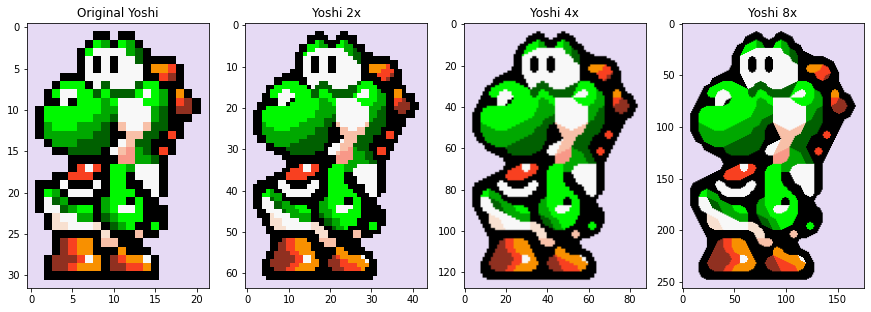

In [3]:
yoshi_path = 'inputs/yoshi.png'
yoshi = cv2.imread(yoshi_path)

yoshi_2x = epx.upsample(yoshi)
yoshi_4x = epx.upsample(yoshi_2x)
yoshi_8x = epx.upsample(yoshi_4x)
utils.display_upscales("Yoshi", [yoshi, yoshi_2x, yoshi_4x, yoshi_8x])

# Option 3 Kopf and Lischinski Algorithm
Milestone steps to upscale 8-bit pixel art vectors:
- Milestone 1: Reshaping the pixels using the heuristics to make sure that they are grouped with their neighbors by creating a similarity graph
- Milestone 2: Create a simplified Voronoi graph from a similarity graph
- Milestone 3: Initializing spline curves from the Voronoi graph
- Milestone 4: Optimizing spline curves by improving locations of control point
- Milestone 5: Rendering


In [35]:
# Milestone 1: Reshaping the pixels using the heuristics to make sure that they are grouped with their neighbors
def create_similarity_graph(image):
    # Create a similarity graph from the input image using heuristics to group similar pixels together.
    img_yuv = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
    graph = networkx.Graph()
    height, width, _ = img_yuv.shape
    print(height, width)

    for y1 in range(height):
        for x1 in range(width):
            # Adding the nodes to the graph
            corners = [(x1, y1), (x1 + 1, y1), (x1, y1 + 1), (x1 + 1, y1 + 1)]
            graph.add_node((x1, y1), value=image[x1, y1, :], corners=corners)

            # Adding the neighbor nodes (8 / 2 = 4 neighbors to ignore repeats)
            neighbors = [(x1 + 1, y1), (x1, y1 + 1) , (x1 + 1, y1 + 1), (x1 + 1, y1 - 1)]
            for neighbor in neighbors:
                x2, y2 = neighbor
                if x2 < width and y2 < height and y2 >= 0 and color_equals(image, x1, y1, x2, y2):
                    # Only add neighbors that are in the same color range
                    graph.add_edge((x1, y1), (x2, y2))  

    return graph

# Remove diagonals if the square is fully connected
def remove_diagonals(graph, image): 
    height, width, _ = image.shape

    for y in range(height - 1):
        for x in range(width - 1):
            corners = graph.nodes[(x, y)]['corners']

            connections = 0
            for i, node1 in enumerate(corners):
                for j, node2 in enumerate(corners[i + 1:]):
                    if graph.has_edge(node1, node2):
                        connections += 1
            
            if connections == 6:
                graph.remove_edges_from([((x, y), (x + 1, y + 1)), ((x + 1, y), (x, y + 1))])
            elif connections == 2 and graph.has_edge((x, y), (x + 1, y + 1)) and graph.has_edge((x + 1, y), (x, y + 1)):
                remove_diagonal_gestalt((x, y), graph)

    return graph

# Remove a single diagonal if the square contains only diagonal connections
def remove_diagonal_gestalt(node, graph):
    # Weights for diagonals where weights[0] is the weight for (x, y) -> (x + 1, y + 1)
    # and weights[1] is the weight for (x + 1, y) -> (x, y + 1)
    x, y = node
    weights = np.array([0, 0])
    weights += getCurvesScore(node, graph)
    weights += getSparsePixelsScore(node, graph)
    weights += getIslandsScore(node, graph)

    if weights[0] > weights[1]:
        graph.remove_edge((x + 1, y), (x, y + 1))
    elif weights[0] < weights[1]:
        graph.remove_edge((x, y), (x + 1, y + 1))
    else:
        graph.remove_edges_from([((x, y), (x + 1, y + 1)), ((x + 1, y), (x, y + 1))])

def getCurvesScore(node, graph):
    return 

def getSparsePixelsScore(node, graph):
    return

def getIslandsScore(node, graph):
    x, y = node
    weight = np.array([0, 0])

    if len(graph.edges((x, y))) == 1:
        weight[0] += 5
    if len(graph.edges((x + 1, y + 1))) == 1:
        weight[0] += 5
    if len(graph.edges((x + 1, y))) == 1:
        weight[1] += 5
    if len(graph.edges((x, y + 1))) == 1:
        weight[1] += 5

    return weight

# Check if the pixels are in equality range according to the Kopf-Lischinski algorithm 
def color_equals(image, x1, y1, x2, y2):
    y, u, v = cv2.split(image.astype(np.int16))

    if 48.0 / 255.0 < abs(y[y1, x1] - y[y2, x2]):
        return False
    if 7.0 / 255.0 < abs(u[y1, x1] - u[y2, x2]):
        return False
    if 6.0 / 255.0 < abs(v[y1, x1] - v[y2, x2]):
        return False
    return True




array([3, 5])

# Run all the helpers

3 3


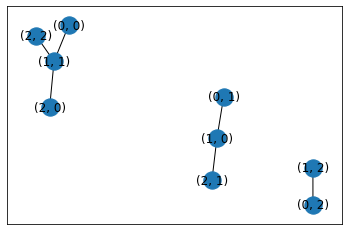

In [36]:
# Convert to grayscale
boo_file = './inputs/test.png'
boo = cv2.imread(boo_file)

graph = create_similarity_graph(boo)
graph = remove_diagonals(graph, boo)

networkx.draw_networkx(graph)
